In [1]:
!pip install -q numpy pandas opencv-python-headless pillow scikit-learn tensorflow keras h5py

In [2]:
!unzip -o data.zip
!unzip -o emojis.zip
!unzip -o haarcascades.zip
!unzip -o pics.zip
!unzip -o tflearn_logs.zip

Archive:  data.zip
   creating: data/
  inflating: data/fer2013.csv        
  inflating: data/README             
Archive:  emojis.zip
   creating: emojis/
  inflating: emojis/angry.png        
  inflating: emojis/disgusted.png    
  inflating: emojis/fearful.png      
  inflating: emojis/happy.png        
  inflating: emojis/neutral.png      
  inflating: emojis/sad.png          
  inflating: emojis/surprised.png    
Archive:  haarcascades.zip
   creating: haarcascades/
  inflating: haarcascades/haarcascade_eye.xml  
  inflating: haarcascades/haarcascade_eye_tree_eyeglasses.xml  
  inflating: haarcascades/haarcascade_frontalface_default.xml  
Archive:  pics.zip
   creating: pics/
  inflating: pics/1happy.jpg         
  inflating: pics/1raf_aligned.png   
  inflating: pics/1sF=1.1.png        
  inflating: pics/1sF=1.3.png        
  inflating: pics/2happy.jpg         
  inflating: pics/2raf_aligned.png   
  inflating: pics/2sF=1.1.png        
  inflating: pics/2sF=1.3.png        
  infl

In [3]:
%%writefile constants.py
# -*- coding:utf-8 -*-
CASC_PATH = 'haarcascades/haarcascade_frontalface_default.xml'
EYE_CASC = 'haarcascades/haarcascade_eye.xml'
EYEGLASSSES_CASC = 'haarcascades/haarcascade_eye_tree_eyeglasses.xml'

SIZE_FACE = 48
SCALEFACTOR = 1.1

EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
RAF_EMOTIONS = ['surprised', 'fearful', 'disgusted', 'happy', 'sad', 'angry', 'neutral']

SAVE_DIRECTORY = 'data'
SAVE_MODEL_FILENAME = 'Gudi_model_100_epochs_20000_faces'

DATASET_CSV_FILENAME = 'fer2013.csv'
SAVE_DATASET_IMAGES_FILENAME = 'data_images.npy'
SAVE_DATASET_LABELS_FILENAME = 'data_labels.npy'

Writing constants.py


In [4]:
%%writefile data_process.py
# -*- coding:utf-8 -*-

from constants import *
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from os.path import join

cascade_classifier = cv2.CascadeClassifier(CASC_PATH)

def format_image(image, flag=0):
    if len(image.shape) > 2 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)

    if flag == 0:
        gray_border = np.zeros((150, 150), np.uint8)
        gray_border[:, :] = 200
        gray_border[
            int((150 / 2) - (SIZE_FACE / 2)): int((150 / 2) + (SIZE_FACE / 2)),
            int((150 / 2) - (SIZE_FACE / 2)): int((150 / 2) + (SIZE_FACE / 2))
        ] = image
        image = gray_border

    faces = cascade_classifier.detectMultiScale(
        image,
        scaleFactor=SCALEFACTOR,
        minNeighbors=5
    )

    if not len(faces) > 0:
        return None

    max_area_face = faces[0]
    for face in faces:
        if face[2] * face[3] > max_area_face[2] * max_area_face[3]:
            max_area_face = face

    face = max_area_face
    image = image[face[1]:(face[1] + face[2]), face[0]:(face[0] + face[3])]

    try:
        image = cv2.resize(image, (SIZE_FACE, SIZE_FACE),
                           interpolation=cv2.INTER_CUBIC) / 255.
    except Exception:
        print("[+] Problem during resize")
        return None

    return image

def emotion_to_vec(x):
    d = np.zeros(len(EMOTIONS))
    d[x] = 1.0
    return d

def flip_image(image):
    return cv2.flip(image, 1)

def data_to_image(data, i):
    data_image = np.fromstring(
        str(data), dtype=np.uint8, sep=' ').reshape((SIZE_FACE, SIZE_FACE))
    data_image = Image.fromarray(data_image).convert('RGB')
    data_image = np.array(data_image)[:, :, ::-1].copy()
    data_image = format_image(data_image)
    return data_image

def get_fer(csv_path):
    data = pd.read_csv(csv_path)
    labels = []
    images = []
    total = data.shape[0]

    for index, row in data.iterrows():
        emotion = emotion_to_vec(row['emotion'])
        image = data_to_image(row['pixels'], index)

        if image is not None:
            labels.append(emotion)
            images.append(image)

        print("Progress: {}/{} {:.2f}%".format(index, total, index * 100.0 / total))

    print(index)
    print("Total: " + str(len(images)))

    np.save(join(SAVE_DIRECTORY, 'sf=' + str(SCALEFACTOR) + '_' + SAVE_DATASET_IMAGES_FILENAME), images)
    np.save(join(SAVE_DIRECTORY, 'sf=' + str(SCALEFACTOR) + '_' + SAVE_DATASET_LABELS_FILENAME), labels)

def rafnum2vec(x):
    d = np.zeros(7)
    d[EMOTIONS.index(RAF_EMOTIONS[x-1])] = 1.0
    return d

def image2array(image_path):
    data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    array = cv2.resize(data, (SIZE_FACE, SIZE_FACE), interpolation=cv2.INTER_CUBIC) / 255.
    return array

def get_raf_aligned(one_dir, one_txt):
    dict_train, dict_test = {}, {}

    for line in open(one_txt, 'r'):
        line = line.strip()
        if line.startswith('train'):
            dict_train[line.split(' ')[0][:11] + '_aligned.jpg'] = int(line.split(' ')[1])
        elif line.startswith('test'):
            dict_test[line.split(' ')[0][:9] + '_aligned.jpg'] = int(line.split(' ')[1])
        else:
            print("wrong!!!")

    images, labels = [], []

    for k, v in dict_train.items():
        image_path = one_dir + k
        image = image2array(image_path)
        images.append(image)
        labels.append(rafnum2vec(v))

    for k, v in dict_test.items():
        image_path = one_dir + k
        images.append(image2array(image_path))
        labels.append(rafnum2vec(v))

    np.save(join(SAVE_DIRECTORY, 'raf_aligned_' + SAVE_DATASET_IMAGES_FILENAME), images)
    np.save(join(SAVE_DIRECTORY, 'raf_aligned_' + SAVE_DATASET_LABELS_FILENAME), labels)

    return "Get aligned!!!"

def get_raf_original(one_dir, one_txt):
    images, labels, count = [], [], 0

    for line in open(one_txt, 'r'):
        line = line.strip()
        image_path = one_dir + line.split(' ')[0]
        image = format_image(cv2.imread(image_path), flag=1)

        if image is not None:
            count += 1
            images.append(image)
            labels.append(rafnum2vec(int(line.split(' ')[1])))

    print(count)

    np.save(join(SAVE_DIRECTORY, 'sf=' + str(SCALEFACTOR) + '_raf_origin_' + SAVE_DATASET_IMAGES_FILENAME), images)
    np.save(join(SAVE_DIRECTORY, 'sf=' + str(SCALEFACTOR) + '_raf_origin_' + SAVE_DATASET_LABELS_FILENAME), labels)

    return "Get original!!!"

if __name__ == '__main__':
    get_fer(join(SAVE_DIRECTORY, DATASET_CSV_FILENAME))

Writing data_process.py


In [5]:
%%writefile dataset_loader.py
# -*- coding:utf-8 -*-

from os.path import join
import numpy as np
from constants import *
from sklearn.model_selection import train_test_split

class DatasetLoader:
    def load_from_save(self):
        images = np.load(join(SAVE_DIRECTORY, 'sf=' + str(SCALEFACTOR) + '_' + SAVE_DATASET_IMAGES_FILENAME))
        images = images.reshape([-1, SIZE_FACE, SIZE_FACE, 1])
        labels = np.load(join(SAVE_DIRECTORY, 'sf=' + str(SCALEFACTOR) + '_' + SAVE_DATASET_LABELS_FILENAME)).\
            reshape([-1, len(EMOTIONS)])
        self._images, self._images_test, self._labels, self._labels_test = train_test_split(
            images, labels, test_size=0.10, random_state=42
        )

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def images_test(self):
        return self._images_test

    @property
    def labels_test(self):
        return self._labels_test

Writing dataset_loader.py


In [6]:
# Run preprocessing to generate data_images.npy and data_labels.npy
!python data_process.py

Streaming output truncated to the last 5000 lines.
Progress: 30889/35887 86.07%
Progress: 30890/35887 86.08%
Progress: 30891/35887 86.08%
Progress: 30892/35887 86.08%
Progress: 30893/35887 86.08%
Progress: 30894/35887 86.09%
Progress: 30895/35887 86.09%
Progress: 30896/35887 86.09%
Progress: 30897/35887 86.10%
Progress: 30898/35887 86.10%
Progress: 30899/35887 86.10%
Progress: 30900/35887 86.10%
Progress: 30901/35887 86.11%
Progress: 30902/35887 86.11%
Progress: 30903/35887 86.11%
Progress: 30904/35887 86.11%
Progress: 30905/35887 86.12%
Progress: 30906/35887 86.12%
Progress: 30907/35887 86.12%
Progress: 30908/35887 86.13%
Progress: 30909/35887 86.13%
Progress: 30910/35887 86.13%
Progress: 30911/35887 86.13%
Progress: 30912/35887 86.14%
Progress: 30913/35887 86.14%
Progress: 30914/35887 86.14%
Progress: 30915/35887 86.15%
Progress: 30916/35887 86.15%
Progress: 30917/35887 86.15%
Progress: 30918/35887 86.15%
Progress: 30919/35887 86.16%
Progress: 30920/35887 86.16%
Progress: 30921/35887

In [7]:
from dataset_loader import DatasetLoader
dl = DatasetLoader(); dl.load_from_save()
print("Train images:", dl.images.shape)
print("Train labels:", dl.labels.shape)
print("Val images:", dl.images_test.shape)

Train images: (19357, 48, 48, 1)
Train labels: (19357, 7)
Val images: (2151, 48, 48, 1)


In [22]:
%%writefile train_keras.py
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from dataset_loader import DatasetLoader
from constants import *
from os.path import join

print("TensorFlow:", tf.__version__)

# load data
dl = DatasetLoader()
dl.load_from_save()
X_train, y_train = dl.images, dl.labels
X_val, y_val = dl.images_test, dl.labels_test

def build_model():
    model = models.Sequential([
        layers.Input(shape=(SIZE_FACE, SIZE_FACE, 1)),

        layers.Conv2D(64, 5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, strides=2),

        layers.Conv2D(64, 5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, strides=2),

        layers.Conv2D(128, 4, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(3072, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(len(EMOTIONS), activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=5e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

# callbacks: safe long training
save_path = join(SAVE_DIRECTORY, SAVE_MODEL_FILENAME + "_keras.h5")
cb_list = [
    callbacks.ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    callbacks.TensorBoard(log_dir="tflearn_logs_keras")
]

# train (up to 100 epochs; EarlyStopping will stop earlier if no improvement)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100,
    shuffle=True,
    callbacks=cb_list
)

model.save(save_path)
print("[+] Model saved to:", save_path)

Overwriting train_keras.py


In [23]:
!python train_keras.py

2025-12-08 20:41:18.825122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765226478.872158   10459 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765226478.882962   10459 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765226478.909908   10459 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226478.909951   10459 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226478.909964   10459 computation_placer.cc:177] computation placer alr

In [24]:
%%writefile predict_keras.py
# predict_keras.py

import argparse
import cv2
import numpy as np
from os.path import isfile
from tensorflow.keras.models import load_model
from constants import *
from PIL import Image

def preprocess_face(gray_img, face):
    # crop -> resize -> scale -> reshape for model
    x, y, w, h = face
    face_img = gray_img[y:y+h, x:x+w]
    try:
        face_img = cv2.resize(face_img, (SIZE_FACE, SIZE_FACE), interpolation=cv2.INTER_CUBIC) / 255.0
    except Exception:
        return None
    return face_img.reshape(1, SIZE_FACE, SIZE_FACE, 1)

def pick_largest_face(faces):
    if len(faces) == 0:
        return None
    max_f = faces[0]
    for f in faces:
        if f[2]*f[3] > max_f[2]*max_f[3]:
            max_f = f
    return tuple(max_f)

def draw_prob_bars(img, probs, emotions, origin=(10,10)):
    # draw list of bars and labels on image (left side)
    x0, y0 = origin
    h_step = 20
    for i, (e, p) in enumerate(zip(emotions, probs)):
        y = y0 + i*h_step
        label = f"{e}: {p*100:.1f}%"
        cv2.putText(img, label, (x0, y+12), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,0), 1)
        cv2.rectangle(img, (x0+120, y+4), (x0+120+int(p*100), y+16), (255,0,0), -1)

def main(args):
    image_path = args.image
    model_path = args.model

    if not isfile(image_path):
        print("Image not found:", image_path); return
    if not isfile(model_path):
        print("Model not found:", model_path); return

    # load model
    model = load_model(model_path)

    # read image
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to read image:", image_path); return

    # grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # face detection
    cascade = cv2.CascadeClassifier(CASC_PATH)
    faces = cascade.detectMultiScale(gray, scaleFactor=SCALEFACTOR, minNeighbors=5)
    face = pick_largest_face(faces)
    if face is None:
        print("No face detected.")
        # save original for reference
        cv2.imwrite('detected_faces_keras.png', image)
        return

    x,y,w,h = face
    # draw rectangle on original image
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)

    # preprocess and predict
    inp = preprocess_face(gray, face)
    if inp is None:
        print("Problem preprocessing face.")
        cv2.imwrite('detected_faces_keras.png', image)
        return

    probs = model.predict(inp)[0]
    top_idx = int(np.argmax(probs))
    top_emotion = EMOTIONS[top_idx]
    top_prob = probs[top_idx]

    # overlay predicted emotion near face
    text = f"{top_emotion} ({top_prob*100:.1f}%)"
    cv2.putText(image, text, (x, y-8), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    # draw probability bars on left
    draw_prob_bars(image, probs, EMOTIONS, origin=(10,10))

    # write result
    out_path = args.output
    cv2.imwrite(out_path, image)
    print("Saved:", out_path)
    # print probabilities
    for e, p in zip(EMOTIONS, probs):
        print(f"{e:10s}: {p*100:.2f}%")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Predict emotion from image using Keras model")
    parser.add_argument("--image", type=str, default="pics/1happy.jpg", help="path to input image")
    parser.add_argument("--model", type=str, default="data/Gudi_model_100_epochs_20000_faces_keras.h5", help="path to keras .h5 model")
    parser.add_argument("--output", type=str, default="detected_faces_keras.png", help="output image path")
    args = parser.parse_args()
    main(args)


Overwriting predict_keras.py


In [25]:
!python predict_keras.py

2025-12-08 20:44:26.724789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765226666.745062   11578 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765226666.751827   11578 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765226666.767377   11578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226666.767403   11578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226666.767407   11578 computation_placer.cc:177] computation placer alr

In [35]:
!python predict_keras.py --image pics/3surprised.jpg --output 3surprised.jpg_out.png

2025-12-08 20:47:09.081765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765226829.101479   12732 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765226829.107423   12732 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765226829.122552   12732 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226829.122579   12732 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226829.122582   12732 computation_placer.cc:177] computation placer alr

In [27]:
!python predict_keras.py --image pics/4disguested.jpg --output disgust_out.png

2025-12-08 20:44:59.028255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765226699.048654   11852 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765226699.054986   11852 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765226699.070659   11852 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226699.070686   11852 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226699.070690   11852 computation_placer.cc:177] computation placer alr

In [28]:
!python predict_keras.py --image pics/5surprised.jpg --output 5surprised.jpg_out.png

2025-12-08 20:45:18.992283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765226719.032795   12003 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765226719.043536   12003 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765226719.067758   12003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226719.067813   12003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226719.067823   12003 computation_placer.cc:177] computation placer alr

In [34]:
!python predict_keras.py --image pics/2happy.jpg --output 2happy.jpg_out.png

2025-12-08 20:46:47.012429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765226807.032099   12571 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765226807.037977   12571 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765226807.053278   12571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226807.053304   12571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765226807.053308   12571 computation_placer.cc:177] computation placer alr

In [37]:
!python predict_keras.py --image emojis/angry.png --output angry.png_out.png

2025-12-08 20:51:09.451953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765227069.474581   13828 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765227069.481350   13828 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765227069.496832   13828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227069.496859   13828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227069.496863   13828 computation_placer.cc:177] computation placer alr

In [38]:
!python predict_keras.py --image emojis/disgusted.png --output disgusted.png_out.png

2025-12-08 20:52:33.481996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765227153.516612   14251 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765227153.527698   14251 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765227153.554284   14251 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227153.554323   14251 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227153.554332   14251 computation_placer.cc:177] computation placer alr

In [40]:
!python predict_keras.py --image emojis/happy.png --output happy.png_out.png

2025-12-08 20:57:31.075242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765227451.095509   15653 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765227451.101598   15653 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765227451.116993   15653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227451.117019   15653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227451.117023   15653 computation_placer.cc:177] computation placer alr

In [43]:
!python predict_keras.py --image emojis/surprised.png --output surprised.png_out.png

2025-12-08 21:01:57.789432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765227717.822517   16986 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765227717.832356   16986 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765227717.856125   16986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227717.856173   16986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765227717.856182   16986 computation_placer.cc:177] computation placer alr

In [30]:
%%writefile predict_cam_video_keras.py
# predict_cam_video_keras.py

import cv2
import numpy as np
from tensorflow.keras.models import load_model
from constants import *
from os.path import isfile
from PIL import Image, ImageFont, ImageDraw

face_cascade = cv2.CascadeClassifier(CASC_PATH)

def crop_and_preprocess(frame, face):
    x,y,w,h = face
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_img = gray[y:y+h, x:x+w]
    try:
        face_img = cv2.resize(face_img, (SIZE_FACE, SIZE_FACE), interpolation=cv2.INTER_CUBIC) / 255.0
    except Exception:
        return None
    return face_img.reshape(1, SIZE_FACE, SIZE_FACE, 1)

def draw_overlay(frame, probs, face):
    # Draw predicted bars and top text
    x,y,w,h = face
    # top text
    top_idx = int(np.argmax(probs))
    text = f"{EMOTIONS[top_idx]} ({probs[0][top_idx]*100:.0f}%)"
    cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    # small vertical bars + labels left
    left_x = 10
    y0 = 10
    for i, e in enumerate(EMOTIONS):
        label = f"{e}: {probs[0][i]*100:4.0f}%"
        yloc = y0 + 20*i
        cv2.putText(frame, label, (left_x, yloc+12), cv2.FONT_HERSHEY_PLAIN, 0.6, (0,255,0), 1)
        cv2.rectangle(frame, (left_x+140, yloc+4), (left_x+140+int(probs[0][i]*100), yloc+16), (255,0,0), -1)

def run(model_path, source=0, output_file=None, webcam=True):
    if not isfile(model_path):
        raise FileNotFoundError("Model not found: " + model_path)

    model = load_model(model_path)
    print("[+] Loaded model:", model_path)

    # source: 0 or video path
    if webcam:
        cap = cv2.VideoCapture(0)
    else:
        cap = cv2.VideoCapture(source)

    if output_file:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 640
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 480
        out = cv2.VideoWriter(output_file, fourcc, 10, (width, height))
    else:
        out = None

    fps_time = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            print("[+] End of video / no frame.")
            break

        # detect faces (use grayscale for cascade)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=SCALEFACTOR, minNeighbors=5)
        if len(faces) > 0:
            # pick largest
            largest = faces[0]
            for f in faces:
                if f[2]*f[3] > largest[2]*largest[3]:
                    largest = f
            x,y,w,h = largest
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

            inp = crop_and_preprocess(frame, largest)
            if inp is not None:
                probs = model.predict(inp)
                # overlay
                draw_overlay(frame, probs, largest)

        # draw FPS
        cur = cv2.getTickCount()
        # show frame
        cv2.imshow("Emotion (press q to quit)", frame)
        if out is not None:
            out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    if out is not None:
        out.release()
    cv2.destroyAllWindows()
    print("[+] Finished.")

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", default="data/Gudi_model_100_epochs_20000_faces_keras.h5")
    parser.add_argument("--source", default="0", help="0 for webcam or path to video file")
    parser.add_argument("--output", default="", help="optional output video path (e.g. out.avi)")
    args = parser.parse_args()

    webcam_flag = (args.source == "0")
    source_arg = 0 if webcam_flag else args.source
    out_arg = args.output if args.output.strip() else None

    try:
        run(args.model, source=source_arg, output_file=out_arg, webcam=webcam_flag)
    except Exception as e:
        print("Error:", e)


Overwriting predict_cam_video_keras.py


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

       angry       0.56      0.53      0.55       272
   disgusted       0.83      0.67      0.74        30
     fearful       0.61      0.50      0.55       295
       happy       0.85      0.86      0.85       594
         sad       0.52      0.36      0.43       277
   surprised       0.77      0.83      0.80       270
     neutral       0.56      0.74      0.63       413

    accuracy                           0.67      2151
   macro avg       0.67      0.64      0.65      2151
weighted avg       0.67      0.67      0.67      2151



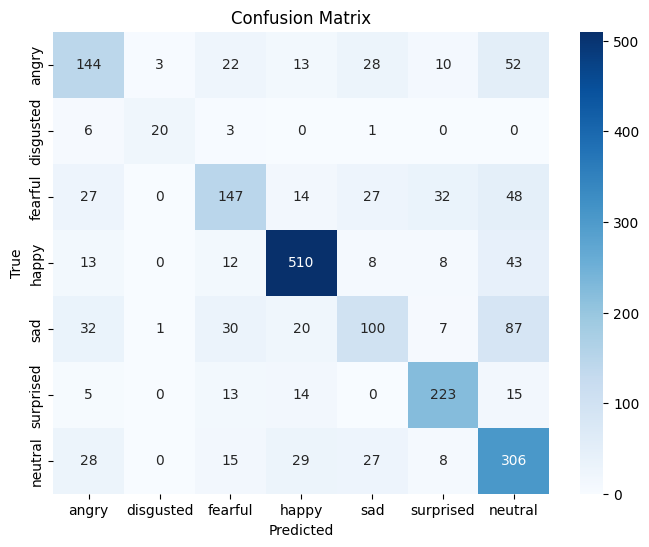

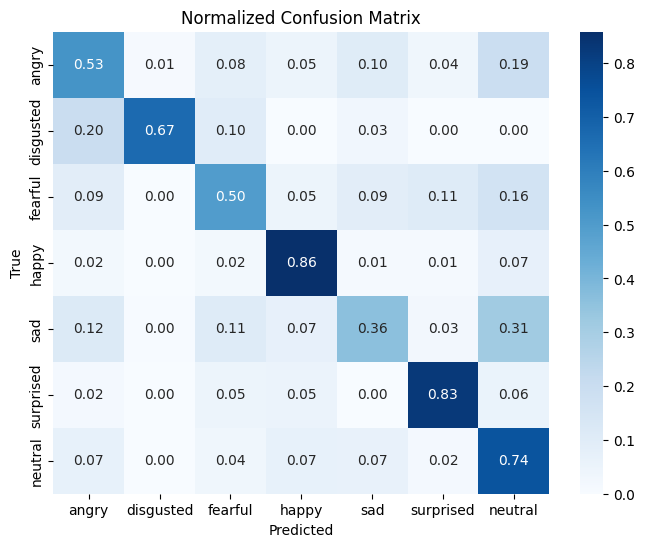

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from dataset_loader import DatasetLoader
from constants import *
import seaborn as sns

# ---- Load Data ---- #
dl = DatasetLoader()
dl.load_from_save()

X_test = dl.images_test
y_test = dl.labels_test
y_true = np.argmax(y_test, axis=1)

# ---- Load Model ---- #
model = load_model("data/Gudi_model_100_epochs_20000_faces_keras.h5")

# ---- Predict ---- #
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# ---- Classification Report ---- #
print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(y_true, y_pred, target_names=EMOTIONS))

# ---- Confusion Matrix ---- #
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- Normalized Confusion Matrix ---- #
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
